# Identifying and differentiating dry beans with the power of machine learning
### by Pranav Mathur
$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\tv}{\mathbf{t}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Im}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}} 
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

## 1. Importing Utilities

In [94]:
from typing import List, Dict, Tuple, Callable, Union
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import pairplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix

## 2. Importing Data

In [5]:
# Load the dataset excel file using pandas
# ENSURE THAT THE PYTHON NOTEBOOK FILE AND THE DATASET 
# FILE ARE IN THE SAME DIRECTORY OR THIS WILL FAIL 
bean_data_excel = pd.ExcelFile('Dry_Bean_Dataset.xlsx')

# load the sheet with the data as a dataframe
bean_df = bean_data_excel.parse('Dry_Beans_Dataset')

## 3. Basic Analysis

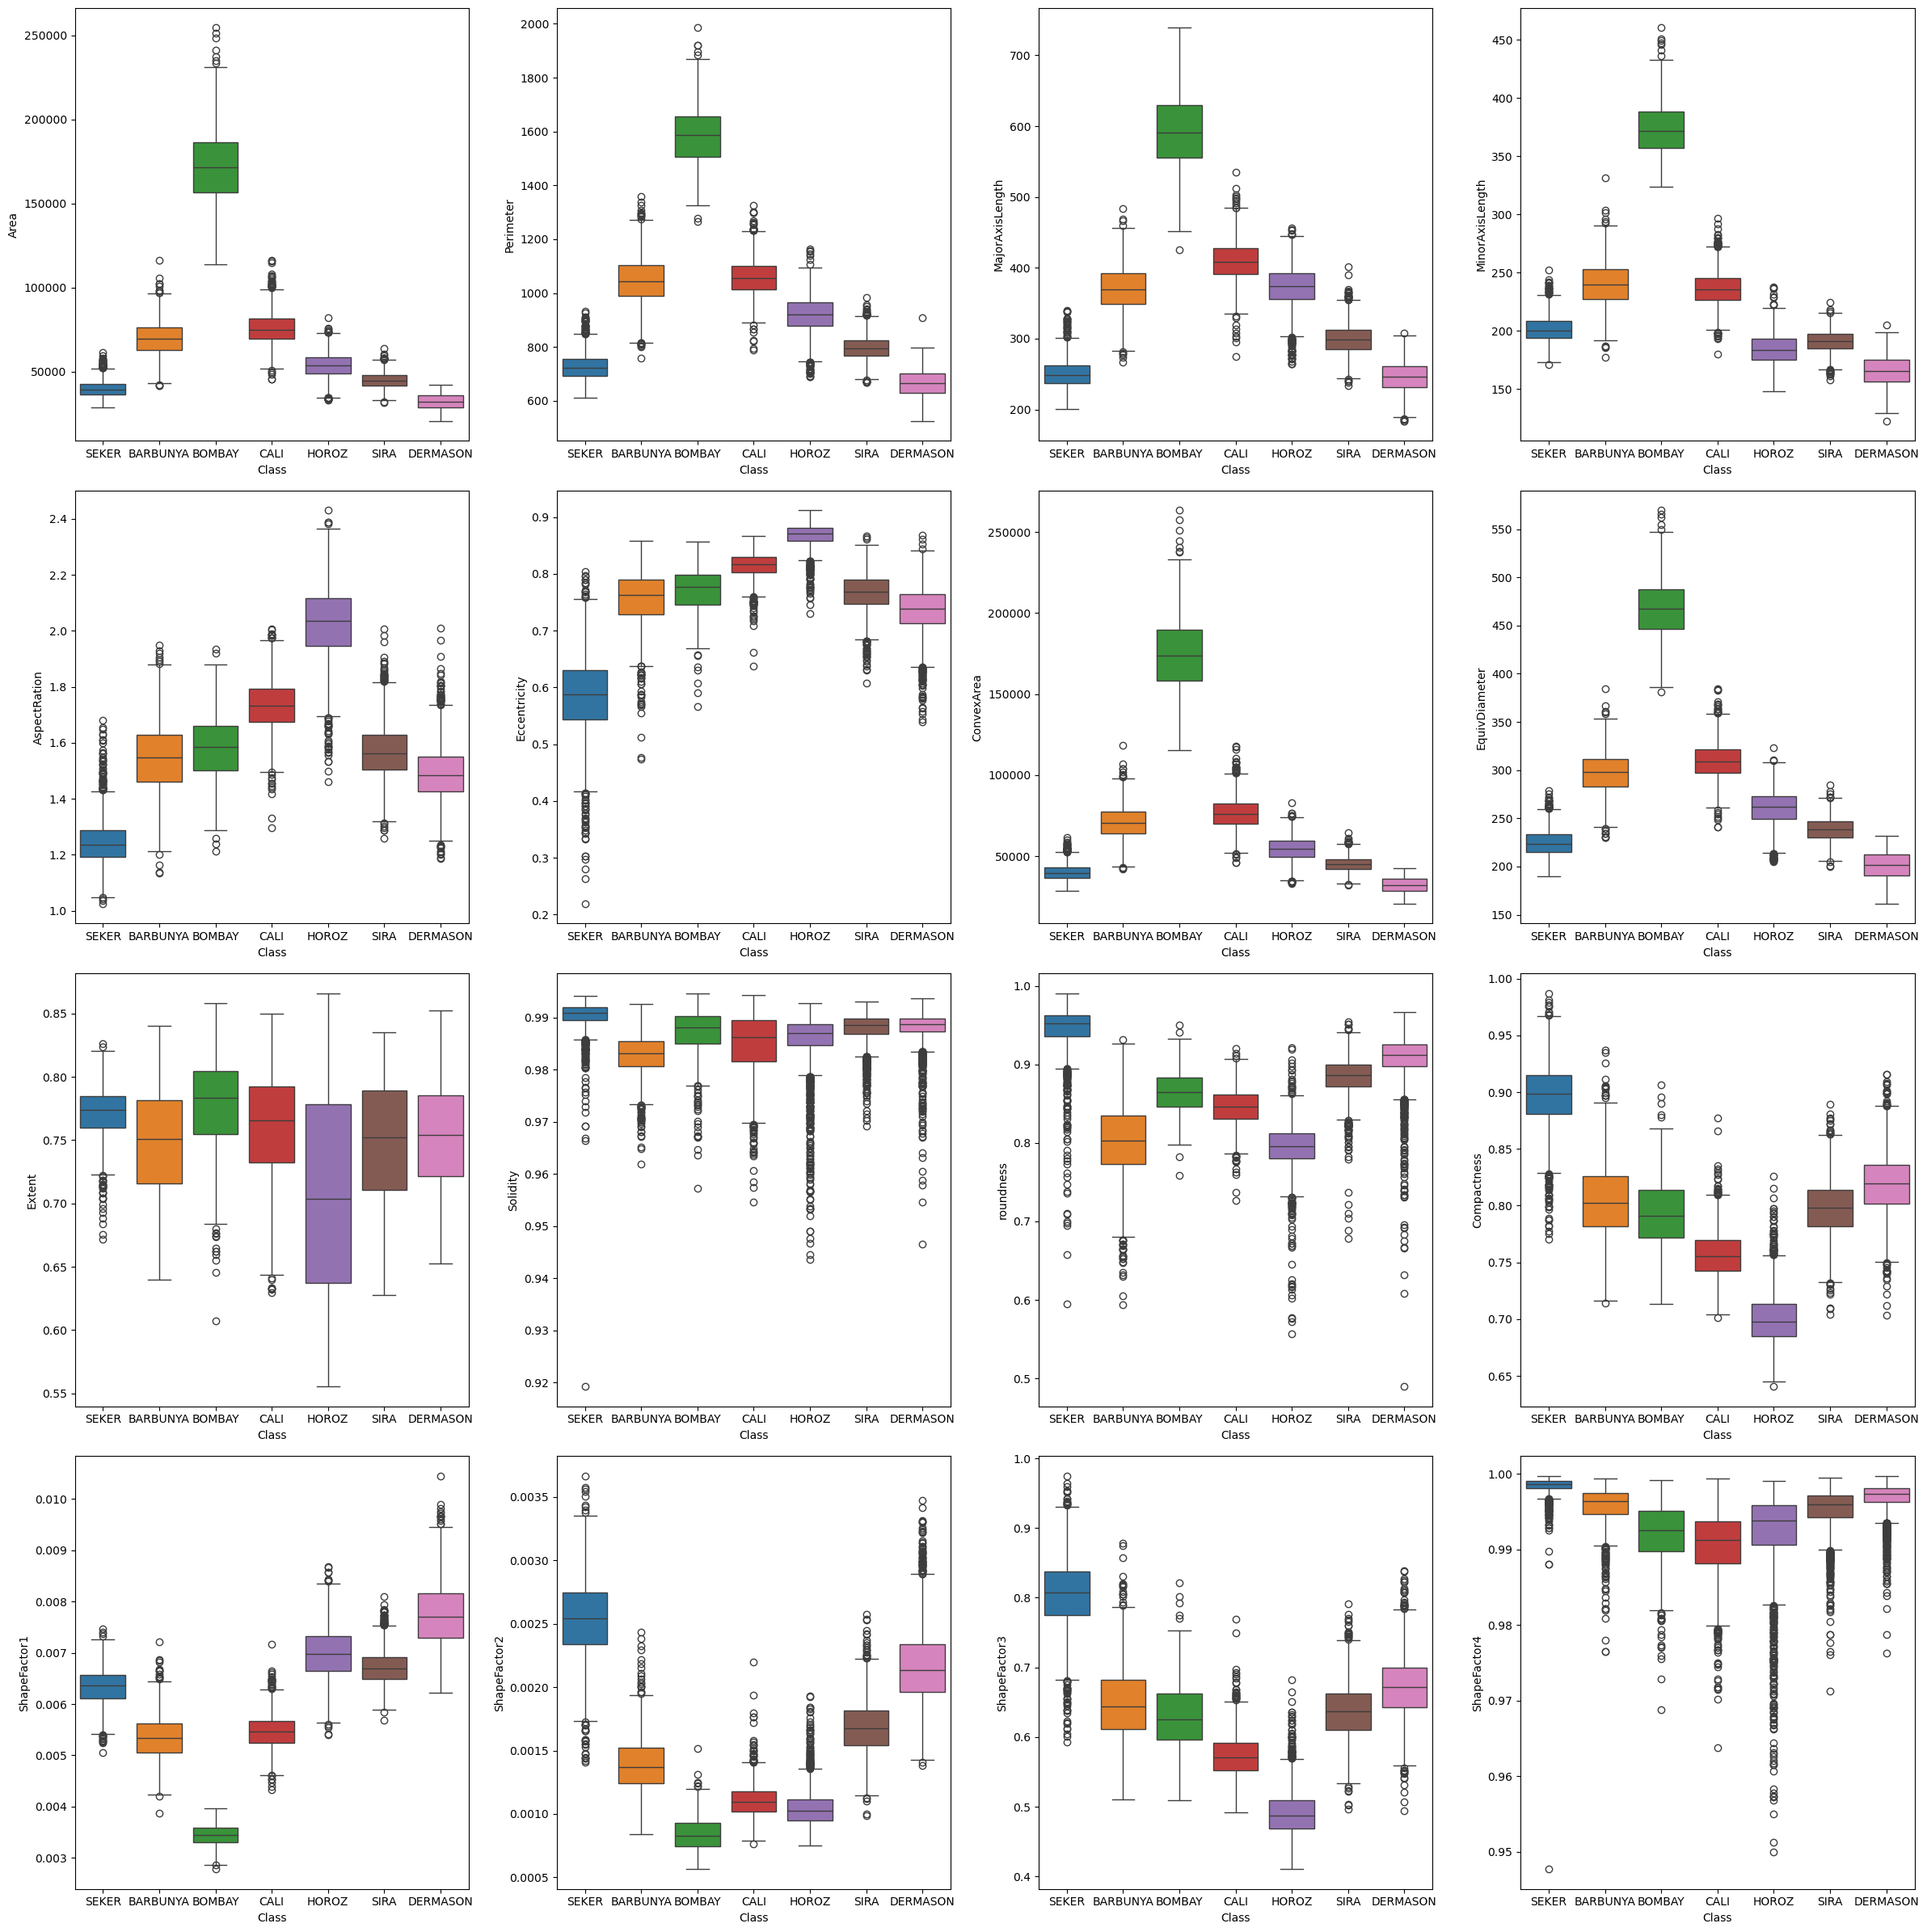

In [7]:
features = bean_df.columns.drop('Class')

n = len(features)
n_cols = int(np.ceil(np.sqrt(n)))
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='Class', y=feature, data=bean_df, ax=axes[i], hue='Class')

plt.tight_layout()
plt.savefig('datasetInitialViz.png')
plt.show()

## 4. Defining Data Preprocessing and Algorithm Functions

In [60]:
def get_preprocessed_data() -> Tuple[np.ndarray, ...]:
    X = bean_df.drop(columns=['Class'])
    y = bean_df.Class

    encoder = OneHotEncoder(sparse_output=False)
    labels_onehot = encoder.fit_transform(y.to_numpy().reshape(-1, 1))
    
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, labels_onehot, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)
    
    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)
    
    X_trn = np.hstack([np.ones((X_trn.shape[0], 1)), X_trn])
    X_vld = np.hstack([np.ones((X_vld.shape[0], 1)), X_vld])
    X_tst = np.hstack([np.ones((X_tst.shape[0], 1)), X_tst]) 
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, encoder

In [106]:
def Softmax(z: np.ndarray) -> np.ndarray:
    z_stable = z - np.max(z, axis=-1, keepdims=True)
    return np.exp(z_stable) / np.sum(np.exp(z_stable), axis=-1, keepdims=True)

class Tanh():
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        return np.tanh(z)

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        return 1 - (np.tanh(z) ** 2)

def init_weights(
    n_input_features: int, 
    hidden_neurons: int, 
    output_neurons: int, 
) -> Tuple[np.ndarray, ...]:
    W1 = np.random.uniform(-0.5, 0.5, size=(n_input_features, hidden_neurons))
    b1 = np.ones((1, hidden_neurons))
    W2 = np.random.uniform(-0.5, 0.5, size=(hidden_neurons, output_neurons))
    b2 = np.ones((1, output_neurons))
    
    return W1, b1, W2, b2

def forward(
    X: np.ndarray, 
    W1: np.ndarray, 
    b1: np.ndarray,
    W2: np.ndarray, 
    b2: np.ndarray, 
) -> Tuple[np.ndarray, ...]:
    Z1 = (X @ W1) + b1
    A1 = Tanh.activation(Z1)
    Z2 = (A1 @ W2) + b2
    A2 = Softmax(Z2)
    
    return Z1, A1, Z2, A2

def output_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    W2_avg_grad = (A1.T @ (A2 - y)) / X.shape[0]  
    b2_avg_grad = np.sum((A2 - y), axis=0, keepdims=True) / X.shape[0]
    return W2_avg_grad, b2_avg_grad

def hidden_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    hidd_err = ((A2 - y) @ W2.T) * Tanh.derivative(Z1)
    W1_avg_grad = (X.T @ hidd_err) / X.shape[0] 
    b1_avg_grad = np.sum(hidd_err, axis=0, keepdims=True) / X.shape[0]
    return W1_avg_grad, b1_avg_grad

def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]
    return batches

class NeuralNetwork():
    def __init__(self,
        hidden_neurons: int,
        output_neurons: int,
        alpha: float, 
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.batch_size = batch_size
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        self.trn_error = None
        self.vld_error = None

    def fit(
        self,
        X: np.ndarray, 
        y: np.ndarray,
        X_vld: np.ndarray = None, 
        y_vld:np.ndarray = None,
    ): 
        np.random.seed(self.seed)
        self.trn_error = []
        self.vld_error = []
        
        # TODO 9.1
        self.W1, self.b1, self.W2, self.b2 = init_weights(X.shape[1], self.hidden_neurons, self.output_neurons)
        
        for e in range(self.epochs):
            batches = get_batches(X.shape[0], self.batch_size)

            for batch_indices in batches:
                X_b = X[batch_indices]
                y_b = y[batch_indices]

                Z1, A1, Z2, A2 = forward(X_b, self.W1, self.b1, self.W2, self.b2)

                W2_avg_grad, b2_avg_grad = output_layer_grads(X_b, y_b, self.W1, Z1, A1, self.W2, Z2, A2)
                W1_avg_grad, b1_avg_grad = hidden_layer_grads(X_b, y_b, self.W1, Z1, A1, self.W2, Z2, A2)

                self.W1 -= self.alpha * W1_avg_grad
                self.b1 -= self.alpha * b1_avg_grad
                self.W2 -= self.alpha * W2_avg_grad
                self.b2 -= self.alpha * b2_avg_grad

            y_hat = self.predict(X)
            self.trn_error.append(nll_loss(y, y_hat))

            if X_vld is not None and y_vld is not None:
                y_hat_vld = self.predict(X_vld)
                self.trn_error.append(nll_loss(y_vld, y_hat_vld))
                
        return self
    
    def predict(self, X: np.ndarray):
        _, _, _, A2 = forward(X, self.W1, self.b1, self.W2, self.b2)
        return A2

def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None
) -> pd.DataFrame:    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    labels = np.sort(np.unique(y))
    
    if class_names is not None:
        labels = class_names

    sns.heatmap(cfm, annot=True, fmt="g", xticklabels=labels, yticklabels=labels)
    plt.show()

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z))

def nll_loss(y: np.ndarray, probs: np.ndarray) -> float:
    return -np.mean(np.sum(y * np.log(probs), axis=1))

def plot_learning_curve(
    trn_error: List[float], 
    vld_error: List[float]
):
    plt.plot(range(len(trn_error)), trn_error, label="Training Error")
    plt.plot(range(len(vld_error)), vld_error, label="Validation Error")
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

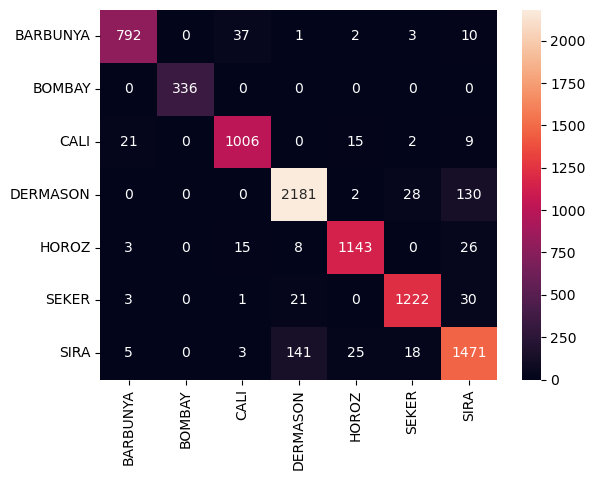

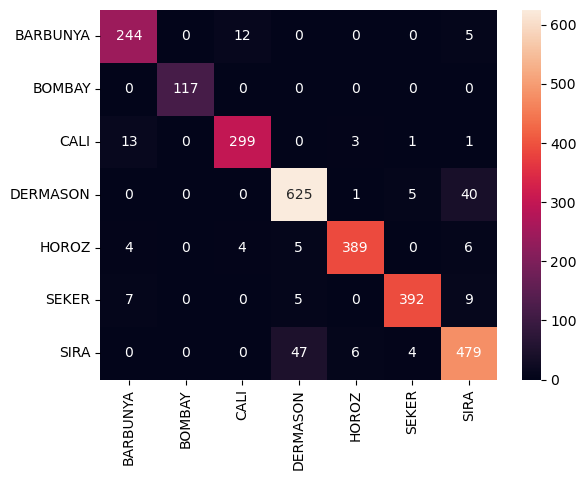

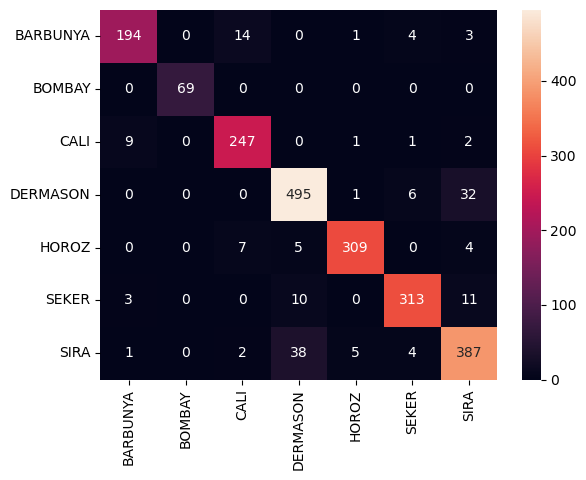

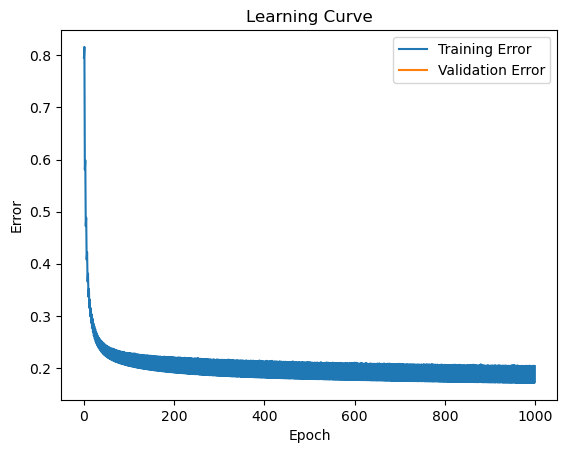

In [114]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, encoder = get_preprocessed_data()

nn = NeuralNetwork(
    hidden_neurons=20,
    output_neurons=7,
    batch_size=32,
    alpha=0.01,
    epochs=500,
    seed=0,
)

nn.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)

y_hat_trn = nn.predict(X_trn)
y_hat_tst = nn.predict(X_tst)
y_hat_vld = nn.predict(X_vld)

plot_confusion_matrix(np.argmax(y_trn, axis=1), np.argmax(y_hat_trn, axis=1), class_names=encoder.categories_[0])
plot_confusion_matrix(np.argmax(y_tst, axis=1), np.argmax(y_hat_tst, axis=1), class_names=encoder.categories_[0])
plot_confusion_matrix(np.argmax(y_vld, axis=1), np.argmax(y_hat_vld, axis=1), class_names=encoder.categories_[0])

plot_learning_curve(nn.trn_error, nn.vld_error)